# A Machine Learning Best Practice
## Data Partitioning for Machine Learning Model Development
Logan Thomas
January 2021

In [1]:
# Standard libraries
from collections import Counter

# Third-party libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from IPython.display import Image
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

## Setup
- The below cells are used to setup the classification problem we aim to solve
- These cells are not intended to be a part of the presentation but serve to instantiate a working dataset for the task at hand

In [2]:
# Set default colors
orange = '#ff7f0e'
blue = '#1f77b4'
cmap = ListedColormap([orange, blue])

# Set default size for all figures
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams["font.size"] = 15

# Flag to save plots as separate PNG images
save_images = False

In [3]:
def decorate_plot(title):
    plt.title(title)
    plt.xlabel('feature_1')
    plt.ylabel('feature_2')
    
    
def plot_dataset(X, y):
    class0_mask = y==0
    
    plt.scatter(
        X[class0_mask][:,0], X[class0_mask][:,1], color=orange, edgecolor='k', label='class_0'
    )
    
    plt.scatter(
        X[~class0_mask][:,0], X[~class0_mask][:,1], color=blue, edgecolor='k', label='class_1'
    )

In [4]:
# Make initial fake data
X, y = make_classification(
    n_features=2,     # total number of features
    n_redundant=0,    # number of redundant features
    n_informative=2,  # number of informative features
    random_state=42,
    n_clusters_per_class=1
)

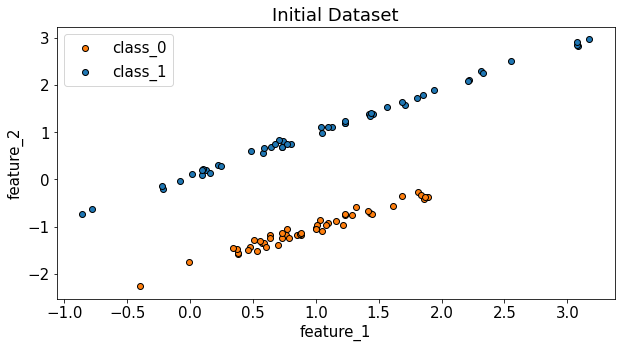

In [5]:
plot_dataset(X, y)
plt.legend(loc='upper left')
decorate_plot('Initial Dataset')

### Add noise to dataset
- We don't want the mock data to be drastically linearly separable
- Two semi-overlapping clusters will suffice

In [6]:
np.random.seed(42)
noise = 2 * np.random.uniform(size=X.shape)
X += noise

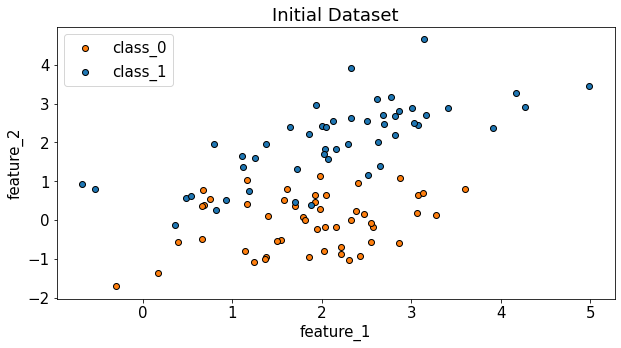

In [7]:
plot_dataset(X, y)
plt.legend(loc='upper left')
decorate_plot('Initial Dataset')

if save_images:
    plt.savefig('images/initial_dataset.png')

# Problem Statement
We have been given the below data set (called the "Initial Dataset"):
- There are `100` data points each with a `feature_1` attribute and `feature_2` attribute
- Each data point also has a corresponding class associated with it (either `class_0` (`y=0`) or `class_1` (`y=1`))
- We have been tasked with creating a classifier that will take this data and produce a classification as an output. Our goal is the learn the relationship between `feature_1` and `feature_2` that corresponds to the specific class labels we see in the data
  - Or in other words, we want to create a classifier that will take `feature_1` and `feature_2` as inputs and produce either a predicted classification of `class_0` (`0`) or `class_1` (`1`) as an output
- Since we have these data-point pairs along with their associated class labels, we have *supervised* learning problem

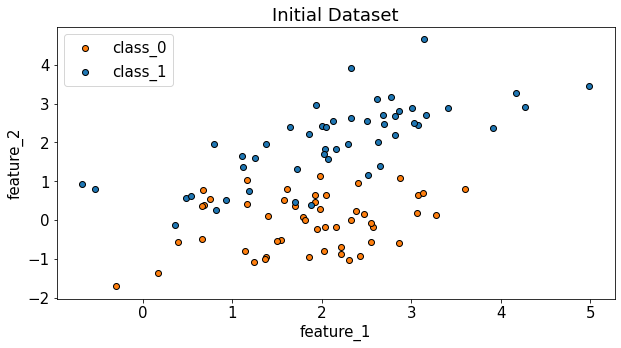

In [8]:
plot_dataset(X, y)
plt.legend(loc='upper left')
decorate_plot('Initial Dataset')

In [9]:
print(X)

[[ 1.97739207e+00  1.14425017e+00]
 [ 2.16239697e+00 -1.82978281e-01]
 [ 2.86085457e+00  2.81424726e+00]
 [ 6.89746037e-01  3.79372861e-01]
 [ 1.78813021e+00  7.86884933e-02]
 [ 6.74730662e-01  7.67031035e-01]
 [ 2.22144873e+00 -8.85706538e-01]
 [ 4.88022206e-01  5.65776347e-01]
 [ 1.93120583e+00  4.56109689e-01]
 [ 2.28975902e+00  1.97248787e+00]
 [ 1.86314665e+00 -9.54967053e-01]
 [ 1.81928420e+00  1.03605974e-03]
 [ 1.65116762e+00  2.39215911e+00]
 [ 2.62075310e+00  3.12883526e+00]
 [ 4.26885030e+00  2.92614934e+00]
 [ 2.21692060e+00 -6.85418925e-01]
 [ 1.16317755e+00  1.04231115e+00]
 [ 2.03447118e+00  1.83470683e+00]
 [ 1.18808637e+00  7.61338375e-01]
 [ 3.07920601e+00  2.44931273e+00]
 [ 1.40276287e+00  1.08679463e-01]
 [ 3.14195650e+00  4.66428257e+00]
 [ 2.40538027e+00  9.58050930e-01]
 [ 1.11070122e+00  1.63984486e+00]
 [ 4.17094785e+00  3.27085627e+00]
 [ 2.16402427e+00  1.84508718e+00]
 [ 3.00891364e+00  2.89201604e+00]
 [ 2.04675508e+00  6.59196311e-01]
 [ 1.68662332e-01 -1

In [10]:
print(y)

[0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1
 1 0 0 1 1 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 1 0
 0 1 0 1 1 0 1 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 1 0 1 1]


In [11]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [12]:
print(X.shape, y.shape)

(100, 2) (100,)


# Problem Statement (cont.)
Before moving on, there are a few assumptions/simplifications we will be using throughout this notebook:
1. This data is fabricated data. All the datasets seen in this notebook are made up and don't have any real meaning (we utilize [`sklearn.datasets.make_classification()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html))
2. There are many different classification models that could be used to solve this problem. For simplicity, we will use a simple Decision Tree Classifier throughout this notebook and not explore other models that could increase classification performance

# Classification Algorithm
For the purpose of this demonstration, we will use a simple [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) as our classification model
- We will set the maximum depth of the tree to `5` to ensure our model doesn't get overly complex
- This is like saying we want the tree to only be `5` levels deep

In [13]:
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X,y)
score = clf.score(X,y)
print(f'Accuracy (entire dataset): {score}')

Accuracy (entire dataset): 0.97


In [14]:
###################################
# Functions for visualizing trees #
###################################
def plot_tree_visual(decision_tree):
    plot_tree(
        decision_tree=decision_tree,
        feature_names=['feature_1', 'feature_2'],
        class_names=['class_0', 'class_1'],
        filled=True,
        rounded=True
    )


def create_contour_grid(X, clf, grid_step=.02):

    # Pseudo boundaries for gird in plotting
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    
    # Complete meshgrid for all datapoints (think "pixels") within plot
    grid_x, grid_y = np.meshgrid(
        np.arange(start=x_min, stop=x_max, step=grid_step),
        np.arange(start=y_min, stop=y_max, step=grid_step)
    )
    
    # Stack all datapoints for prediction
    # np.c_ is like np.column_stack (but faster?)
    stacked_points = np.c_[grid_x.ravel(), grid_y.ravel()]
    
    # Countour height (color label)
    grid_z = clf.predict_proba(stacked_points)[:,1]
    
    # Reshape to mimic xx and yy shape for plotting
    grid_z = grid_z.reshape(grid_x.shape)
    
    return grid_x, grid_y, grid_z


def plot_tree_boundaries(X, y, grid_x, grid_y, grid_z, title):
    
    # Plot the countour gird (this is the classification algo decision boundary)
    plt.contourf(grid_x, grid_y, grid_z, cmap=cmap)
    
    # Plot the actual data points seen
    plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap, edgecolors='k')
    
    # Plot the accuracy of the classification algo in the upper right of the plot
    plt.text(
        x=grid_x.max() - .05,
        y=grid_y.max() - .6,
        s=f"Acc: {clf.score(X,y):.2f}",
        horizontalalignment='right',
        fontdict={'color':'white', 'fontsize': 15}
    )
    
    decorate_plot(title)

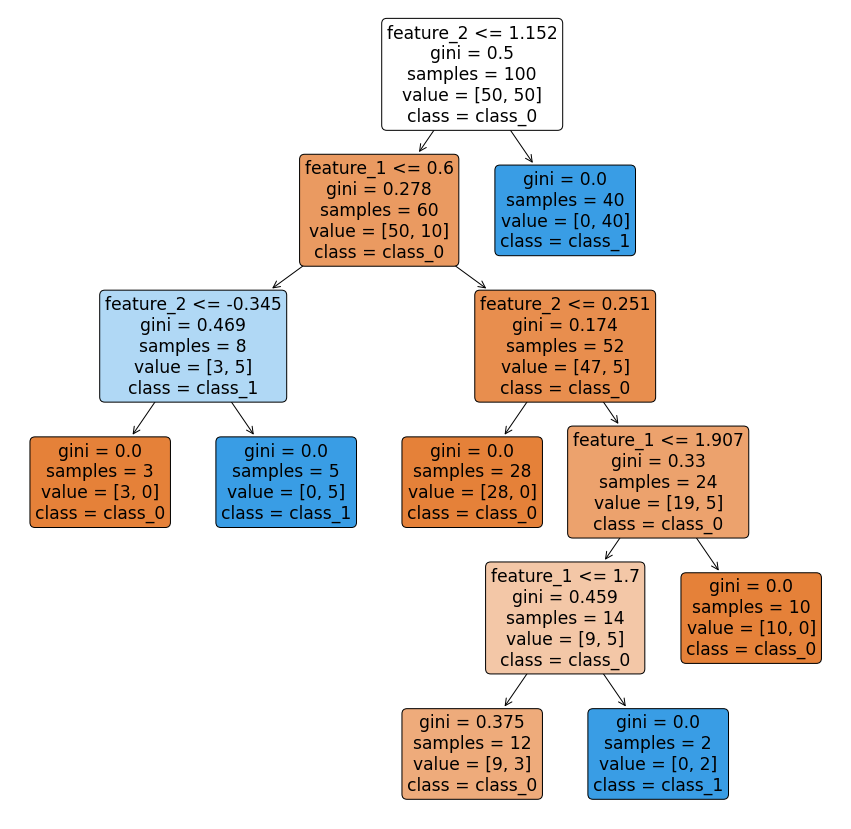

In [15]:
plt.figure(figsize=(15,15))
plot_tree_visual(clf)

if save_images:
    plt.savefig('images/decison_tree_viz_initial_classification.png')

0.97

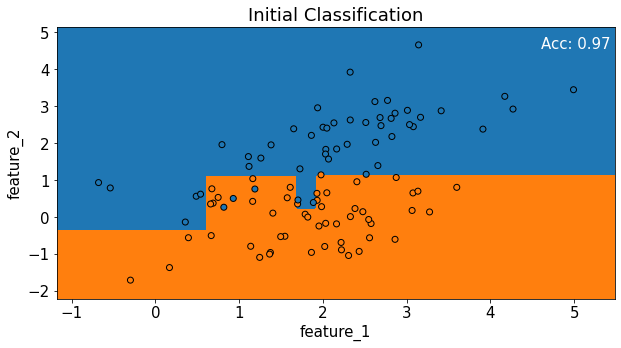

In [16]:
grid_x, grid_y, grid_z = create_contour_grid(X, clf, grid_step=.02)
plot_tree_boundaries(X, y, grid_x, grid_y, grid_z, title='Initial Classification')

if save_images:
    plt.savefig('images/decison_tree_boundary_initial_classification.png')
    
clf.score(X, y)

# Discussion
Fantastic! We were able to create a simple classifier (Decision Tree) that has a `97%` accuracy score when applied to the initial dataset. We are feeling pretty good.


Now, suppose a new batch of data has come through the pipeline:
- Let's see how our classifier performs on this second set of data **that it has never seen before**
- **Note**: we are NOT re-training our classifier, we are applying it to new data
  - This means we should see the same decision boundary when we plot the contour with new data

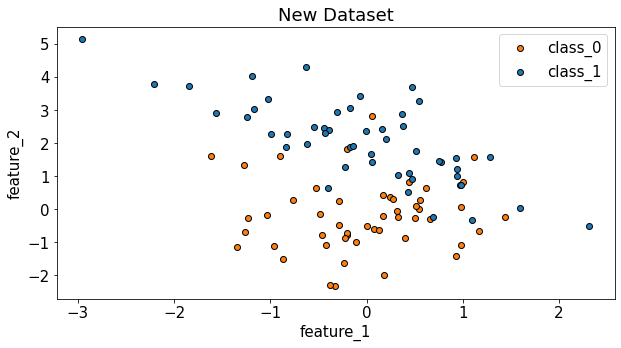

In [17]:
# Second set of data that our model has never seen
X2, y2 = make_classification(
    n_features=2,     # total number of features
    n_redundant=0,    # number of redundant features
    n_informative=2,  # number of informative features
    random_state=53,
    n_clusters_per_class=1
)

X2 += noise

plot_dataset(X2, y2)
plt.legend(loc='upper right')
decorate_plot('New Dataset')

if save_images:
    plt.savefig('images/new_dataset.png')

0.7

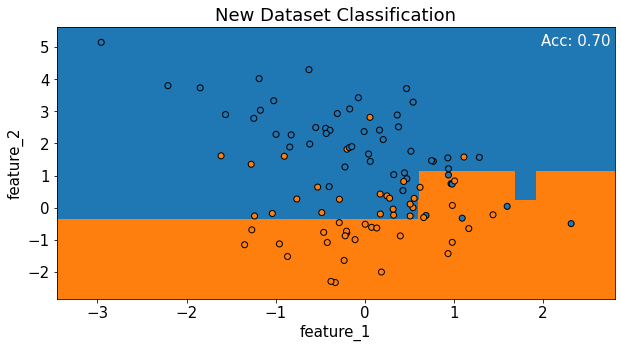

In [18]:
grid_x2, grid_y2, grid_z2 = create_contour_grid(X2, clf, grid_step=.02)
plot_tree_boundaries(X2, y2, grid_x2, grid_y2, grid_z2, title='New Dataset Classification')

if save_images:
    plt.savefig('images/decison_tree_boundary_new_data_classification.png')
    
clf.score(X2, y2)

# Discussion
Uh-oh. What happened here?
- We saw `97%` accuracy when we first trained our model on the initial dataset
- When we applied that same classification model to new data (that the model has never seen), we saw a dramatic degradation in our accuracy
- What is going on?
- Let's look at both the datasets to compare and see if there are dramatic differences

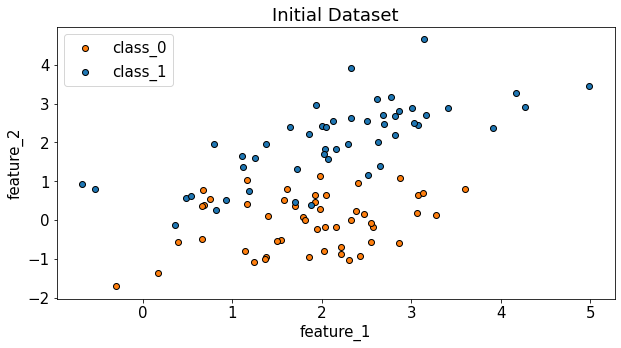

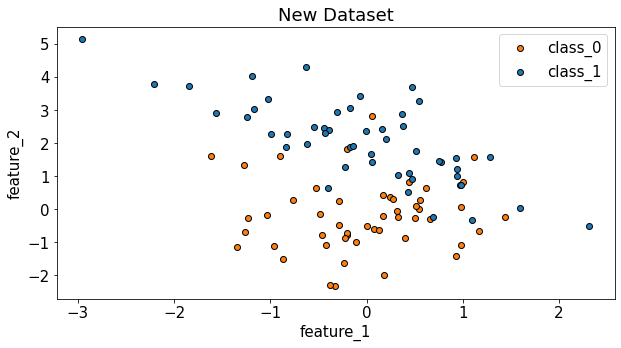

In [19]:
plot_dataset(X, y)
plt.legend(loc='upper left')
decorate_plot('Initial Dataset')
plt.show()

plot_dataset(X2, y2)
plt.legend(loc='upper right')
decorate_plot('New Dataset')
plt.show()

## Discussion (cont.)
The two datasets seem to be comparable, but do have some differences
- Both datasets seem to be somewhat linearly separable
  - If we drew a line where `feature_2 = 1`, both datasets would seem to be divided into classes
- `class_1` in the initial dataset seems to follow a somewhat linearly increasing pattern where in the new data set it seems to follow a somewhat linearly decreasing pattern
- `class_0` in the initial dataset seems to be somewhat random in its distribution but falls in the range of `~[0,3]` for `feature_1`. In the new dataset, `class_0` is still somewhat random but extends the distribution for `feature_1` to include quite a few values below `0`.

So at a high level, these two datasets differ but not drastically. So why does our classifier behave so poorly on the new dataset?
- It seems like our classifier is behaving well for the initial dataset but that doesn't translate to the new dataset
- In other words, our classifier isn't generalizing well


What we are seeing here is a typical problem encountered in machine learning called **overfitting**
- We have created a classifier that is overfit to our initial dataset
- It has learned the nuances of the initial training dataset so well that it is not robust to other inputs it would see from newly acquired data
- Overfitting occurs when a model learns the details of data it was trained on to the extent that it negatively impacts the performance of the model on new data

---

## Potential Solution
How do we combat overfitting? We have a few options:
1. We can consider the classification model we are using
  - Typically, a Decision Tree falls victim to overfitting (a disadvantage of using Decstion Trees is their habit of overfitting to their training set)
  - We *could* combat this by using an ensemble of Decision Trees and inject some randomness by selecting a subset of features and samples from the dataset to create an ensemble learner.
  - This is called a Random Forrest model
  - We could also explore other classification models like k-nearest-neighbors, support vector machines, or a neural network
  - For the purpose of this demonstration, we won't explore this option and stick with our simple Decision Tree classifier

2. We could re-train our classification model every time we see new data
  - This would require aggregating our initial dataset with any new datasets that come through the pipeline. In essence, we'd be creating a *master* dataset that keeps growing over time
  - We could also just create a new model every time we see new data (but train it specifically and only on the new data)
  - Both of these approaches aren't efficient and would require some heavy-lifting when it comes to maintenance.
  - We'd be creating a new classifier for each batch of data and would have to maintain each of those models in case we had to do retroactive case studies
    - What if we had a scenario where new data came through the pipeline every month? How would we compare classification outputs for the month of January to the month of May?
    - We'd need to retain the data and model for each month in order to conduct this study
  - Furthermore, this doesn't truly solve our overfitting problem. We might be creating models that are specific to each month and are overfit for the specific data available at that time. We would hope that as our dataset grew, our model would become more generalized, but there is no guarantee this would happen
  - For these reasons, we won't be exploring this option

3. We could create a training and testing dataset based on the initial data and use that to inform decisions on classification model
  - In this scenario, we'd break up our initial training data into `2` datasets (one for model training and one for model evaluation)
  - In this paradigm, a classifier would be trained on a subset of the initial data we were given and tested on a subset of the same data that the model never saw during training
  - This allows us to get a feel for how the model would perform in the "real-world" and make adjustments to the model before deploying it to production
  - Here lies the objective of this demonstration, exploring this idea of a training and testing data split
  
---

## Train-Test Split
Our goal is to divide our initial dataset into two subsets:
1. A `train` dataset that will be used to train our classification model
2. A `test` dataset that will be used to evaluate the performance of our model on data it has never seen during training
  - We initially trained on **all** of the data we were given and then were surprised to see that our model did not generalize well to new data
  - Instead, we will only use a subset of the data for training and decrease the chances of our model overfitting to our initial dataset
  - We can get a feel for how our model will perform on new data by giving it the `test` dataset and seeing how it performs
  
---

## Manual Splitting
We can perform this splitting operation manually in `4` steps:
1. Create an array of indices that corresponds to each datapoint in our initial dataset
2. Shuffle this array of inidices to create a randomized set of indices
3. Slice the array based on a prescribed number of points that are desired to be in the `train` and `test` datasets
  - This is typically a 60-40, 70-30, or 80-20 split for train-test respectively
4. Gather the corresponding datapoints and their class labels based on the slices obtained in step 3

In [20]:
np.random.seed(9)

# Step 1
idx = np.arange(len(X))

# Step 2
np.random.shuffle(idx)

# Step 3
n_train_perc = 0.6
n_train = int(n_train_perc*len(X))

train_idx = idx[:n_train]
test_idx = idx[n_train:]

# Step 4
X_train = X[train_idx]
y_train = y[train_idx]

X_test = X[test_idx]
y_test = y[test_idx]

print(sorted(Counter(y).items()))
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_test).items()))

[(0, 50), (1, 50)]
[(0, 29), (1, 31)]
[(0, 21), (1, 19)]


In [21]:
def plot_split_dataset(X_train, X_test, y_train, y_test):
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='train', markerfacecolor='w', markeredgecolor='k'),
        Line2D([0], [0], marker='^', color='w', label='test', markerfacecolor='w', markeredgecolor='k'),
        Line2D([0], [0], marker='s', color='w', label='class_0', markerfacecolor=orange, markeredgecolor=orange),
        Line2D([0], [0], marker='s', color='w', label='class_1', markerfacecolor=blue, markeredgecolor=blue),
    ]

    plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=cmap, edgecolors='k', label='train')
    plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap=cmap, edgecolors='k', alpha=0.7, marker='^', label='test')
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0.)

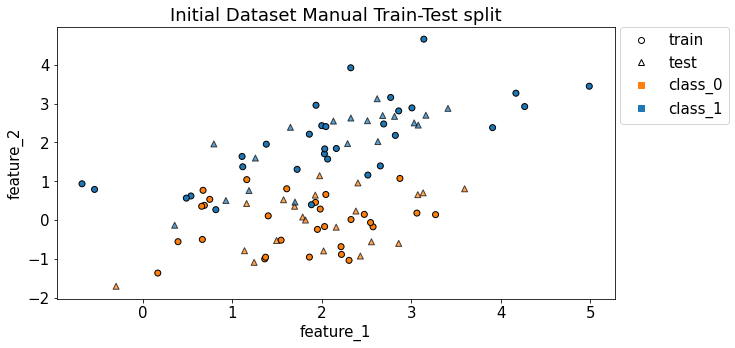

In [22]:
plot_split_dataset(X_train, X_test, y_train, y_test)
decorate_plot('Initial Dataset Manual Train-Test split')

if save_images:
    plt.tight_layout()
    plt.savefig('images/manual_split_initial_dataset.png')

## Train our classification model only on the training data

In [23]:
clf.fit(X_train, y_train)
score = clf.score(X_train,y_train)
print(f'Accuracy (manual training dataset): {score:.3f}')

Accuracy (manual training dataset): 0.983


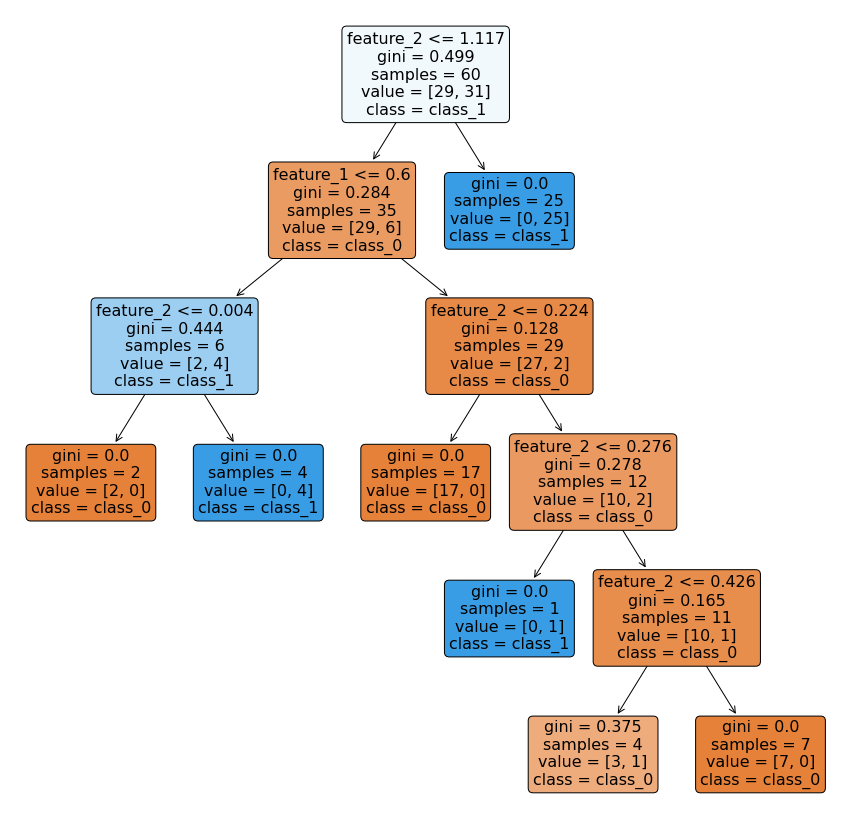

In [24]:
plt.figure(figsize=(15,15))
plot_tree_visual(clf)

if save_images:
    plt.savefig('images/decison_tree_viz_manual_split_classification.png')

In [25]:
# The grid is still based on the entire dataset
# Only the clf model has changed (this doesn't have to do with the train-test split)
grid_x, grid_y, grid_z = create_contour_grid(X, clf, grid_step=.02)

0.9833333333333333

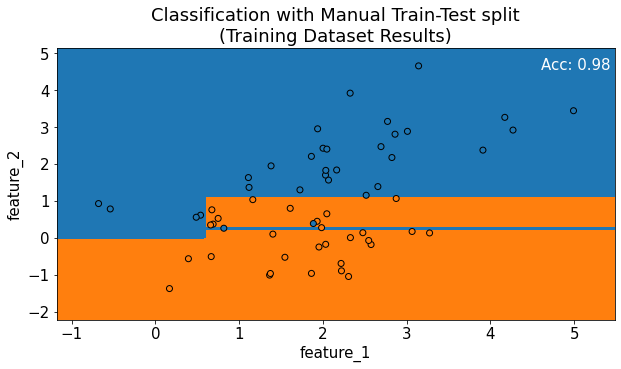

In [26]:
plot_tree_boundaries(
    X_train,
    y_train,
    grid_x,
    grid_y,
    grid_z,
    title='Classification with Manual Train-Test split\n(Training Dataset Results)'
)


if save_images:
    plt.savefig('images/manual_split_train_score.png')
    
clf.score(X_train, y_train)

0.85

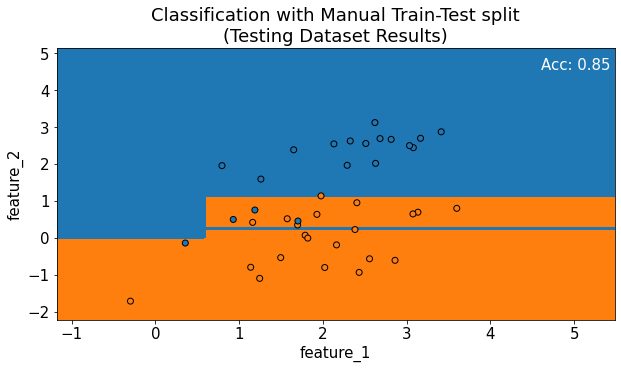

In [27]:
plot_tree_boundaries(
    X_test,
    y_test,
    grid_x,
    grid_y,
    grid_z,
    title='Classification with Manual Train-Test split\n(Testing Dataset Results)'
)

if save_images:
    plt.savefig('images/manual_split_test_score.png')
    
clf.score(X_test, y_test)

0.78

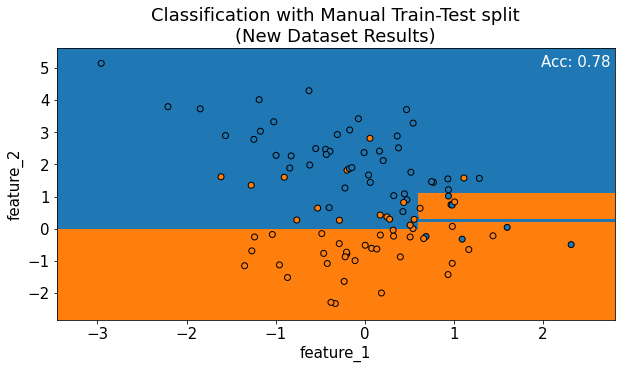

In [28]:
grid_x2, grid_y2, grid_z2 = create_contour_grid(X2, clf, grid_step=.02)

plot_tree_boundaries(X2, y2, grid_x2, grid_y2, grid_z2, title='Classification with Manual Train-Test split\n(New Dataset Results)')


if save_images:
    plt.savefig('images/manual_split_new_data_score.png')
    
clf.score(X2, y2)

# Discussion
In the above cells, we fit our simple classifier using the training dataset (not the entire dataset), applied this learned classifier to our testing dataset (yielding an accuracy of `85%`), and the applied the same classifier trained only on the training set to the new data (yielding an accuracy of `78%`)
- When plotting the decision boundary and the training dataset, it looks like the learned classifier is a bit less complex than our original trained model (on the entire dataset)
- What we really care about is how this newly trained model performed on "out-of-sample" data or data that the model has never seen before
  - We get a feel for this when we apply the model to the `train` set and/or the new dataset acquired (`X2`)
- When we compare the original classifier trained on the entire data set (accuracy of `70%`) and the newly trained model only using a training subset of the data (accuracy of `78%`), we see that our partitioning approach did yield better accuracy and helped us combat overfitting

---

We have covered a simple manual approach for splitting (or partitioning) or initial dataset into a `train` and `test` subset
- Although this manual process isn't incorrect, there is a better (or more convenient way) to partition our data
- Scikit-Learn provides a handy function ([`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)) that can be used to accomplish this same task but also provides some more functionality than our basic manual procedure


## Leverage `sklearn.model_selection.train_test_split()`

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=.6,
    random_state=16,
)

print(sorted(Counter(y).items()))
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_test).items()))

[(0, 50), (1, 50)]
[(0, 32), (1, 28)]
[(0, 18), (1, 22)]


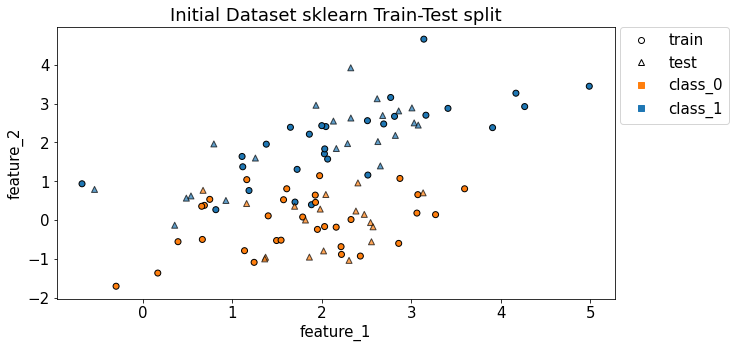

In [30]:
plot_split_dataset(X_train, X_test, y_train, y_test)
decorate_plot('Initial Dataset sklearn Train-Test split')

if save_images:
    plt.tight_layout()
    plt.savefig('images/sklearn_split_initial_dataset.png')

In [31]:
# Train our classification model only on the training data
clf.fit(X_train, y_train)
score = clf.score(X_train,y_train)
print(f'Accuracy (sklearn training dataset): {score:.3f}')

Accuracy (sklearn training dataset): 0.967


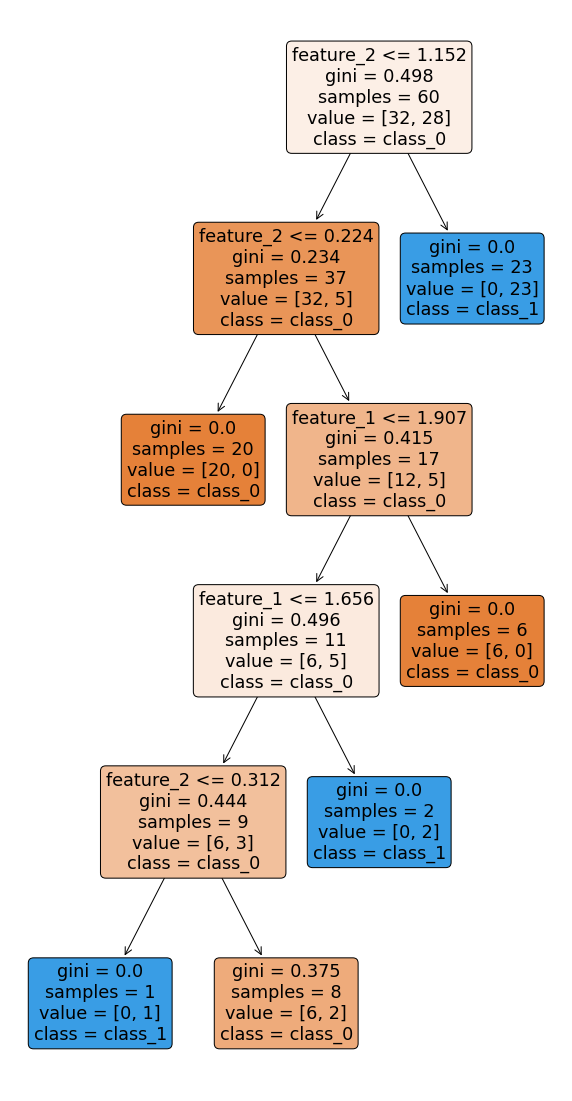

In [32]:
plt.figure(figsize=(10,20))
plot_tree_visual(clf)

if save_images:
    plt.savefig('images/decison_tree_viz_sklearn_split_classification.png')

In [33]:
# The grid is still based on the entire dataset
# Only the clf model has changed (this doesn't have to do with the train-test split)
grid_x, grid_y, grid_z = create_contour_grid(X, clf, grid_step=.02)

0.9666666666666667

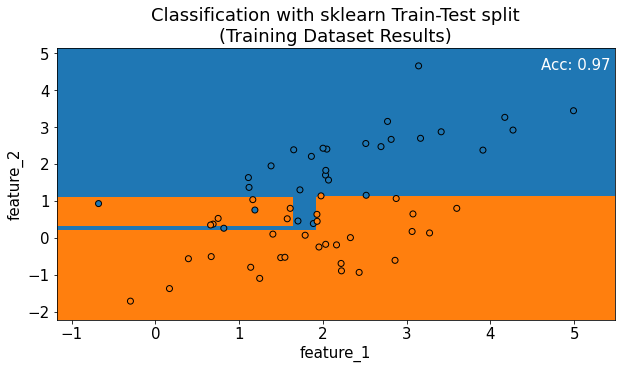

In [34]:
plot_tree_boundaries(
    X_train,
    y_train,
    grid_x,
    grid_y,
    grid_z,
    title='Classification with sklearn Train-Test split\n(Training Dataset Results)'
)

if save_images:
    plt.savefig('images/sklearn_split_train_score.png')
    
clf.score(X_train, y_train)

0.85

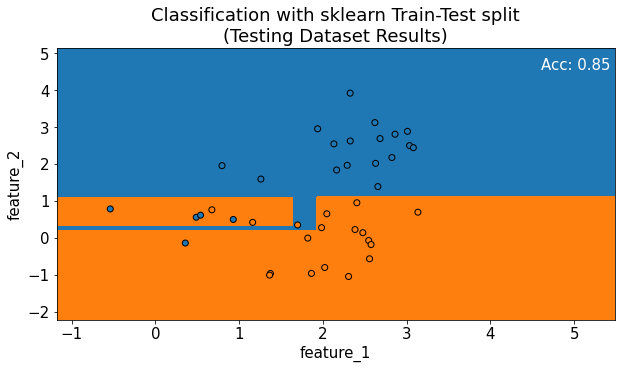

In [35]:
plot_tree_boundaries(
    X_test,
    y_test,
    grid_x,
    grid_y,
    grid_z,
    title='Classification with sklearn Train-Test split\n(Testing Dataset Results)'
)

if save_images:
    plt.savefig('images/sklearn_split_test_score.png')
    
clf.score(X_test, y_test)

0.78

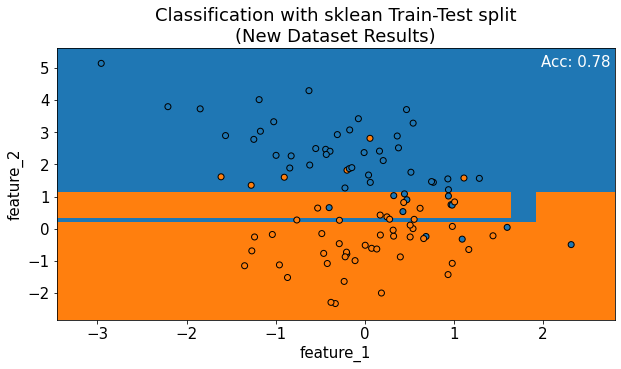

In [36]:
grid_x2, grid_y2, grid_z2 = create_contour_grid(X2, clf, grid_step=.02)
plot_tree_boundaries(X2, y2, grid_x2, grid_y2, grid_z2, title='Classification with sklean Train-Test split\n(New Dataset Results)')

if save_images:
    plt.savefig('images/sklearn_split_new_data_score.png')
    
clf.score(X2, y2)

# Discussion
In the above cells, we used `sklearn`'s `train_test_split()` function to perform a similar process as our manually defined procedure we used before
- The resulting train-test splits won't be identical between the two approaches, but the underlying processes are similar
- Now, the previous ~20 lines of code we implemented can be replaced by a single function call
- This isn't the only benefit we get from using the `train_test_split()` function
- Let's revisit the original data set and our previous partitioning approaches

In [37]:
#######################################
# Original Dataset Class Distribution #
#######################################
print(f'Original Dataset Class Distribution: {sorted(Counter(y).items())}\n')

#######################
# Manual Partitioning #
#######################
np.random.seed(9)

# Step 1
idx = np.arange(len(X))

# Step 2
np.random.shuffle(idx)

# Step 3
n_train_perc = 0.6
n_train = int(n_train_perc*len(X))

train_idx = idx[:n_train]
test_idx = idx[n_train:]

# Step 4
X_train = X[train_idx]
y_train = y[train_idx]

X_test = X[test_idx]
y_test = y[test_idx]

print('Manual Partitioned Class Distribution:')
print(f'\ttrain dist: {sorted(Counter(y_train).items())}')
print(f'\ttest dist : {sorted(Counter(y_test).items())}\n')

########################
# sklearn Partitioning #
########################
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=.6,
    random_state=16,
)

print('sklearn Partitioned Class Distribution:')
print(f'\ttrain dist: {sorted(Counter(y_train).items())}')
print(f'\ttest dist : {sorted(Counter(y_test).items())}')

Original Dataset Class Distribution: [(0, 50), (1, 50)]

Manual Partitioned Class Distribution:
	train dist: [(0, 29), (1, 31)]
	test dist : [(0, 21), (1, 19)]

sklearn Partitioned Class Distribution:
	train dist: [(0, 32), (1, 28)]
	test dist : [(0, 18), (1, 22)]


# Discussion (cont.)
Do you notice anything odd about the output class distributions in our training and testing subsets?
- Our initial dataset had an even split of `class_0` and `class_1` datapoints (`50` points from each class)
- The train and test datasets we previously created (both manually and using `train_test_split()`) **do not** follow this 50-50 class distribution in the original dataset
- In a perfect world, we'd be able to split our dataset to mimic the distribution of `50% class_0` and `50% class_1` in both our training and testing datasets
- This notion of creating a subset that mirrors the distribution of classes found in the original dataset is called *stratified sampling*
- We aren't currently taking this approach into account, but `sklearn`'s `train_test_split()` provides a clean way to implement this idea

## Leverage `sklearn.model_selection.train_test_split()` with stratified sampling
- Notice the output of the print statements
- Now, our train and test subsets have a class distribution that mimics the original dataset

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=.6,
    random_state=6,
    stratify=y,
)

print(sorted(Counter(y).items()))
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_test).items()))

[(0, 50), (1, 50)]
[(0, 30), (1, 30)]
[(0, 20), (1, 20)]


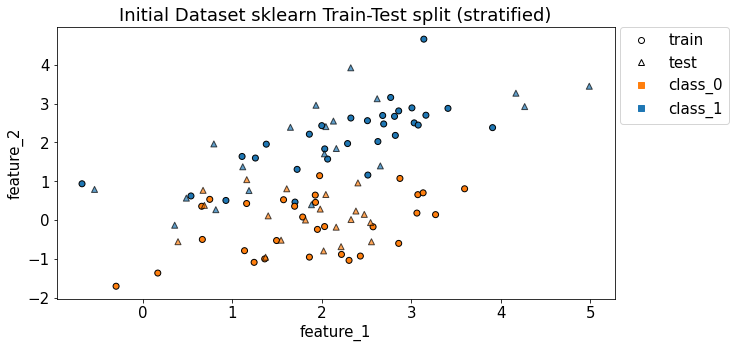

In [39]:
plot_split_dataset(X_train, X_test, y_train, y_test)
decorate_plot('Initial Dataset sklearn Train-Test split (stratified)')

if save_images:
    plt.tight_layout()
    plt.savefig('images/sklearn_stratified_split_initial_dataset.png')

In [40]:
# Train our classification model only on the training data
clf.fit(X_train, y_train)
score = clf.score(X_train,y_train)
print(f'Accuracy (sklearn stratified training dataset): {score:.3f}')

Accuracy (sklearn stratified training dataset): 1.000


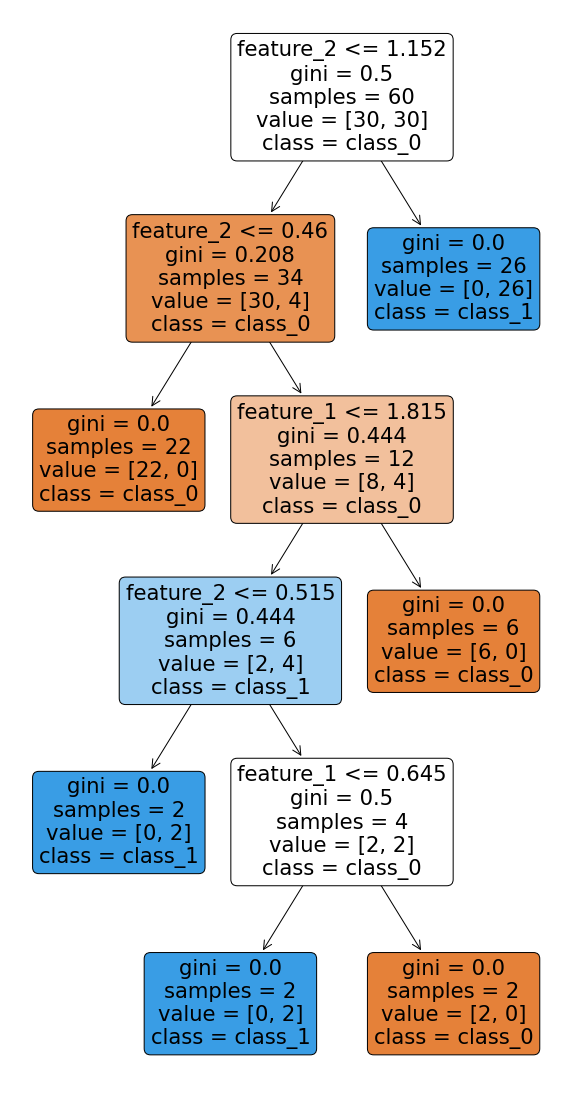

In [41]:
plt.figure(figsize=(10, 20))
plot_tree_visual(clf)

if save_images:
    plt.savefig('images/decison_tree_viz_sklearn_stratified_split_classification.png')

In [42]:
# The grid is still based on the entire dataset
# Only the clf model has changed (this doesn't have to do with the train-test split)
grid_x, grid_y, grid_z = create_contour_grid(X, clf, grid_step=.02)

1.0

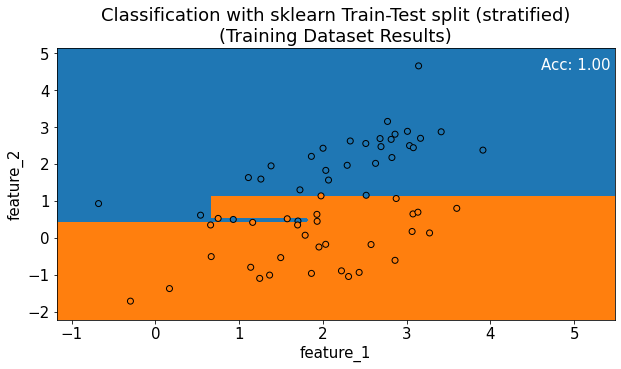

In [43]:
plot_tree_boundaries(
    X_train,
    y_train,
    grid_x,
    grid_y,
    grid_z,
    title='Classification with sklearn Train-Test split (stratified)\n(Training Dataset Results)'
)

if save_images:
    plt.savefig('images/sklearn_stratified_split_train_score.png')
    
clf.score(X_train, y_train)

0.9

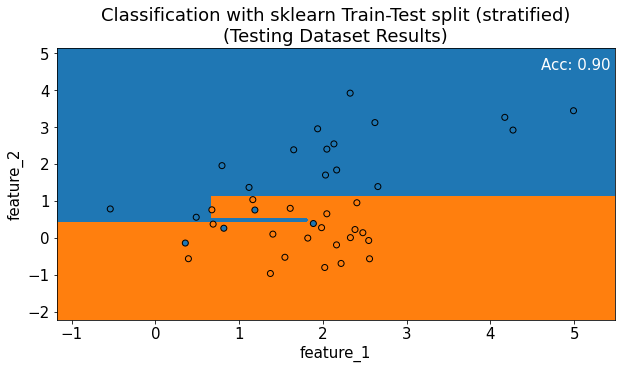

In [44]:
plot_tree_boundaries(
    X_test,
    y_test,
    grid_x,
    grid_y,
    grid_z,
    title='Classification with sklearn Train-Test split (stratified)\n(Testing Dataset Results)'
)

if save_images:
    plt.savefig('images/sklearn_stratified_split_test_score.png')
    
clf.score(X_test, y_test)

0.84

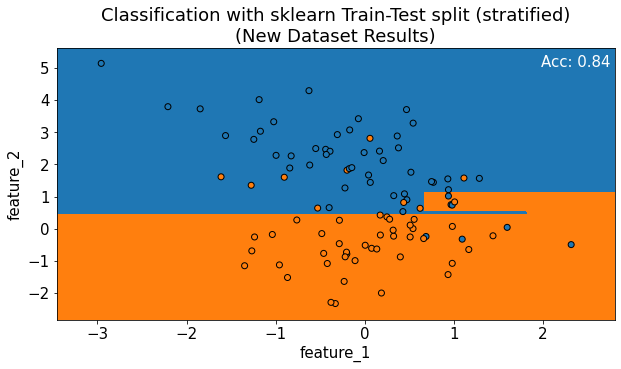

In [45]:
grid_x2, grid_y2, grid_z2 = create_contour_grid(X2, clf, grid_step=.02)
plot_tree_boundaries(X2, y2, grid_x2, grid_y2, grid_z2, title='Classification with sklearn Train-Test split (stratified)\n(New Dataset Results)')

if save_images:
    plt.savefig('images/sklearn_stratified_split_new_data_score.png')
    
clf.score(X2, y2)

# Discussion
After utilizing `sklearn`'s `train_test_split()` function with stratification to create our training and testing datasets, we fit another model on the stratified training dataset. We can see another improvement in the model's performance (the accuracy on the new dataset has jumped to `84%`)
- A summary table is provided below
- Notice that the training data does increase slightly for each approach, but we are truly interested in how the newly fit models generalize to out-of-sample data (i.e. the testing and new dataset accuracy)

| Approach                        | Training Accuracy | Testing Accuracy | New Dataset Accuracy |
| :------------------------------ | :---------------: | :--------------: | :------------------: |
| No Partition                    |               97% |              N/A |                  70% |
| Manual Train-Test               |               98% |              85% |                  78% |
| sklearn Train-Test              |               97% |              85% |                  78% |
| sklearn (stratified) Train-Test |              100% |              90% |                  84% |

---

# Further Enhancements
There are a few more enhancements or improvements we can make to our data partitioning approach that builds off of the train-test split concept. These two methods are particularly useful when comparing not just one, but multiple classification models (i.e. when the goal is to select a single classification model when many models can be used to solve the problem at hand).

## Train-Validation-Test Partitioning
Good Resource: [Training Sets, Validation Sets, and Holdout Sets](https://www.datarobot.com/wiki/training-validation-holdout/)
- Up to this point, we have been splitting our initial dataset into two distinct subsets: a training dataset and a testing dataset (as shown below)

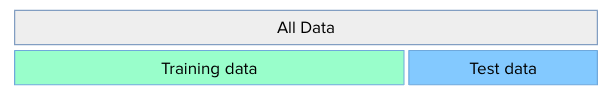

In [46]:
Image('images/train-test-split.png')

## Train-Validation-Test Partitioning (cont.)
Another partitioning approach takes the above a step further and splits the initial dataset into **three** distinct subsets (as shown below):
- The training set is used the same way we have seen in the past -- for fitting a classification model
- The validation set acts as a "test" set during model fine-tuning and/or model comparison phases
- The test set (orange below) is used as a final holdout set for final model comparison and selection

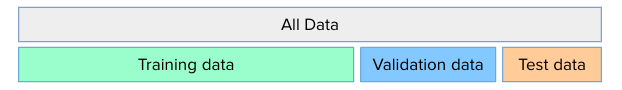

In [47]:
Image('images/train-validation-test-split.png')

Essentially, this approach allows us to reserve a true out-of-sample slice of our original data (the test set in orange) for a final model evaluation step
- This orange data slice will produce a better estimate of out-of-sample performance because a model will never see this data during any of the training phase processes

To further show the benefits of this approach consider these examples:
- Scenario 1:
  - We'd like to create a simple classifier (just one model) and evaluate it's performance on unseen data
  - We can use the train-test partitioning approach to fit the classifier on the training data and estimate the out-of-sample performance on the test set
  
- Scenario 2:
  - We'd like to compare multiple classification models and evaluate each model's performance on unseen data
  - If we used a simple train-test partitioning approach, each model would be fit on the training data and evaluated based on the test set. The hyper-parameters for each of these models will be fine-tuned until yielding the best results on the testing dataset. But now, each model has seen the testing dataset (and possibly seen it multiple times depending on how much fine-tuning was performed). How can we truly select the best classification model?
  - Instead of just a train and test partition, we can create a train, validation and test split
  - Each model is trained on the training data and fine tuned using the validation data
  - Once each model has reached it's peak performance, we "lock" each model's parameters and perform a final evaluation of the models on the holdout (orange) dataset
  - This allows us to pick the best performing model based on a true out-of-sample accuracy estimate

## Cross-Validation
Good Resources:
-  [Selecting the Best Model in scikit-learn Using Cross-Validation](https://www.youtube.com/watch?v=6dbrR-WymjI)
- [scikit-learn Cross-Validation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)
- [Cross-Validation in scikitlearn Tutorial](https://www.youtube.com/watch?v=L_dQrZZjGDg)

Another enhancement that can be made to the train-test split approach is something called *Cross-Validation*
- This is similar to the train-validation-test splitting approach but involves a more complex procedure
- Given an initial dataset, two subsets of data are created: a training and testing set
- The test set (in blue at the top and at the bottom in orange) is held out for final model evaluation and only used once for final model selection (just like in the train-validation-test approach)
- Now, instead of creating a distinct validation dataset from the original data, the training set is split into *k* smaller sets called "folds"
- For each fold:
  - A model is trained using all of the folds, except one, as training data
  - The resulting model is then *validated* on the fold that was left out during training
  - In the image below, the first iteration would used fold 2, fold 3, fold 4, and fold 5 to fit a model. Then, this model would be validated on fold 1
- After all fold-iterations are complete, the accuracy reported by each fold-iteration is averaged across all of the iterations to yield an overall estimate of performance
- Although computationally expensive, cross-validation is a good approach for model evaluation as it makes better used of the training data and ensures all datapoints within the training partition will be used at least once within a validation set

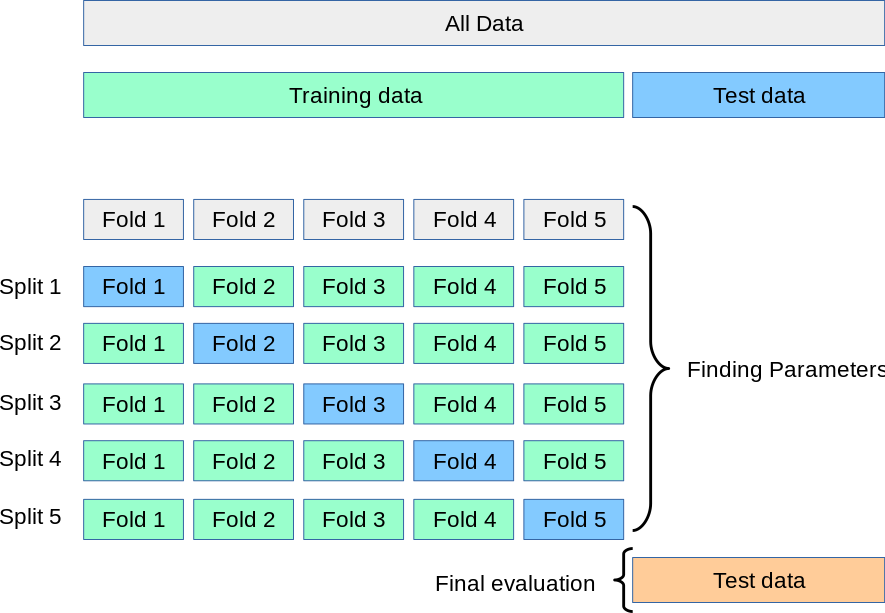

In [48]:
Image('images/sklearn_cross_validation_image.png')

## Cross-Validation: Applied

In [49]:
# split into training (used for CV) and testing (final eval)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(80, 2) (80,)
(20, 2) (20,)


In [50]:
def summarize_clf(clf, X_train, X_test, y_train, y_test, X2, y2):
    
    # 5-fold cross-validation
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Scores                  : {scores}")
    
    # use average accuracy as an estimate of out-of-sample accuracy
    print(f"Cross-Validated Accuracy: {scores.mean()} (+- {scores.std()*2:.3f})")
    
    clf.fit(X_train, y_train)
    print(f"Train Accuracy          : {clf.score(X_train, y_train)}")
    print(f"Test Accuracy           : {clf.score(X_test, y_test)}")
    print(f"New data Accuracy       : {clf.score(X2, y2)}")

In [51]:
seed=5

In [52]:
# No change here, just for reference
dt = DecisionTreeClassifier(max_depth=5, random_state=seed)
summarize_clf(dt, X_train, X_test, y_train, y_test, X2, y2)

Scores                  : [0.875 1.    0.75  0.875 1.   ]
Cross-Validated Accuracy: 0.9 (+- 0.187)
Train Accuracy          : 0.9875
Test Accuracy           : 0.8
New data Accuracy       : 0.7


In [53]:
# If maximum depth of the tree is `None`, then nodes are expanded until all leaves are pure or
# until all leaves contain less than min_samples_split samples.
dt2 = DecisionTreeClassifier(random_state=seed)
summarize_clf(dt2, X_train, X_test, y_train, y_test, X2, y2)

Scores                  : [0.9375 1.     0.75   0.875  1.    ]
Cross-Validated Accuracy: 0.9125 (+- 0.187)
Train Accuracy          : 1.0
Test Accuracy           : 0.85
New data Accuracy       : 0.71


In [54]:
rf = RandomForestClassifier(n_estimators=25, random_state=seed)
summarize_clf(rf, X_train, X_test, y_train, y_test, X2, y2)

Scores                  : [0.875  0.9375 0.875  0.875  0.9375]
Cross-Validated Accuracy: 0.9 (+- 0.061)
Train Accuracy          : 1.0
Test Accuracy           : 0.85
New data Accuracy       : 0.74


In [55]:
rf2 = RandomForestClassifier(random_state=seed)
summarize_clf(rf2, X_train, X_test, y_train, y_test, X2, y2)

Scores                  : [0.9375 1.     0.875  0.875  1.    ]
Cross-Validated Accuracy: 0.9375 (+- 0.112)
Train Accuracy          : 1.0
Test Accuracy           : 0.85
New data Accuracy       : 0.77


# Discussion
Notice that we are using 5-fold cross-validation in the `summarize_clf()` function
- The resulting output is a list of `5` scores for each fold-iteration and the final cross-validation accuracy measurement is the average of these scores
- If we were to compare our 4 models (`dt`, `dt2`, `rf`, and `rf2`), we'd see that the `rf2` model yields the best cross-validation accuracy.
- Fitting each model on the training data (and applying it to the training and new dataset), we see that our intuition is correct and the `rf2` model performs the best on unseen or out-of-sample data

# Closing Thoughts

One of the primary reasons we evaluate machine learning models is so that we can choose the best available model so solve the problem at hand
- The goal of supervised learning (the classification problem used in this notebook) is to build a classifier that will generalize to out-of-sample data (or data a model has never seen before)
- Thus, we need a model evaluation procedure that allows us to estimate how well a given model is likely to perform on out-of-sample data
- We use this performance estimate to choose between available models

So, what is a good "model evaluation procedure" that allows us to estimate how well a model is likely to perform on out-of-sample data?

### No Partitioning
We first explored training a model on the *entire* dataset and then evaluating that model by testing how well it performed on the same dataset
- In this approach, the same data was used to train/fit a classifier as well as provide an evaluation
- Here, the evaluation metric is known as "training accuracy" (since we really only has a training dataset)
- This approach to model evaluation is not ideal as it rewards overly complex models that are unlikely to generalize to future data (overfitting to the training dataset)
  
### Train-Test Partitioning
An alternative approach we explored was the `train-test-split` procedure
- Here, we partitioned the data into two distinct datasets known as the training and testing sets
- We trained a model on the training set and we evaluated the model by analyzing it's performance on the testing set
- This resulting evaluation metrics is known as the testing accuracy -- which is a better estimate of out-of-sample performance than training accuracy
- We get a better estimate for out-of-sample performance with this approach because the model it trained and tested on different datasets
- Testing accuracy doesn't reward models that are fined-tuned to a specific training dataset and helps to avoid overfitting

### Train-Validation-Test Partitioning
The `train-test-split` procedure is a great mental model and widely-used process when creating machine learning models. However, it does come with a few drawbacks:
- Testing accuracy is a high variance estimate of out-of-sample accuracy
- This means that the testing accuracy can change quite a bit depending on which observations happen to be selected for the testing set (due to random choice when partitioning)
- If the same training and testing set are used multiple times, over and over, to compare and evaluate models, we could start to overfit the testing dataset
- One way to combat this is to partition the data into `3` distinct subsets (`train`, `validation`, and `test`)
  - The train dataset is used to train models
  - The validation dataset is used to compare models and fine-tune parameters
  - The test dataset is used once and only once to evaluate and compare final models
  
### Cross-Validation
The above two partitioning approaches work well when evaluating different settings ("hyper-parameters") for classifiers. However, there is still a risk of overfitting the *test set* because the parameters can be tweaked until the classifier performs optimally on the test set. When this occurs, knowledge about the test set can "leak" into the model and evaluation metrics no longer report on generalization performance.
- The `train-validation-test` approach aims to solve this problem by creating a validation set and holdout set for performance evaluation. Training is done on the training set, evaluation is done on the validation set, and when the model(s) reach its final state, final evaluation is performed on the test set
- However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for training a model.
- Furthermore, the results are dependent on the particular random selection for both the validation and test set (locked into whatever datapoints are selected for these data subsets)

To solve this problem, cross-validation can be used
- A test set is still held out for final evaluation, but the validation set is no longer needed
- Instead, the training data is split into `k` smaller sets called folds
- For each fold, a model is trained using `k-1` of the folds as training data and the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute performance)
- The performance reported by k-fold cross-validation is the average of the values computed in the loop.
- This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set).

One important note about cross-validation: it will not produce a final model
- The purpose of CV is model *checking* not model *building*
- Say we have two models, say a linear regression model and a neural network. How can we say which model is better? We can do K-fold cross-validation and see which one proves better at predicting the test set points. But once we have used cross-validation to select the better performing model, we train that model (whether it be the linear regression or the neural network) on all the data (training data used for CV). We don't use the actual model instances we trained during cross-validation for our final predictive model.

A few recommendations when using cross-validation
- `k=10` is generally recommended because it has been shown experimentally to produce the most reliable estimates of out-of-sample accuracy
- When using cross-validation with classification problems, it is recommended that you use stratified sampling to create folds (much like we did with the `train-test-spit` approach)
- `sklearn` uses stratified sampling by default when using `cross_val_score()`:
>For `cv=int/None` inputs, if the estimator is a classifier and ``y`` is either binary or multiclass, `StratifiedKFold` is used. In all other cases, `KFold` is used.



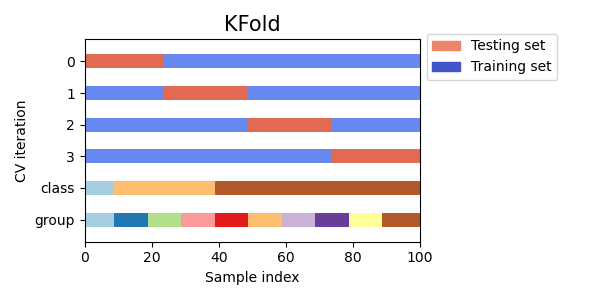

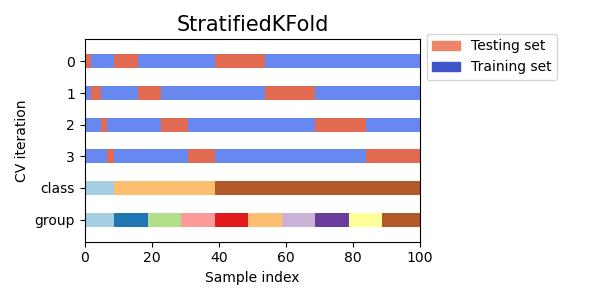

In [56]:
display(Image('images/sklearn-kfold-image.png'))
display(Image('images/sklearn-stratified-kfold-image.png'))

## Approach Comparison
In most cases, a cross-validation approach is recommended. However, there are cases when a `train-test` or `train-validation-split` approach may be warranted.
- The main reason we prefer cross-validation to `train-test-split` is that cross-validation generates a more accurate estimate of out-of-sample accuracy (which is what we need to choose the best model)
- Cross-validation uses the data more efficiently that `train-test-split` since every observation is used both in training and testing the model

There are two primary advantages to using `train-test-split` instead of cross-validation
1. `train-test-split` runs `k` times faster than `k`-fold cross-validation
  - Cross-validation repeats the `train-test-split` process `k` times
  - This is an important consideration for larger datasets as well as models that take a long time to train
2. It is much easier to examine the detailed results of the testing process from `train-test-split`
  - We can implement cross-validation easily with `sklearn` but only the performance metrics are returned. This makes it difficult to inspect the results using a confusion matrix or ROC curve
  - `train-test-split` makes it easy to examine these results as we can inspect the performance on the validation (or test) datasets